### Recurrent Neural Network from scratch
* https://www.analyticsvidhya.com/blog/2019/01/fundamentals-deep-learning-recurrent-neural-networks-scratch-python/

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sin_wave = np.array([np.sin(x) for x in np.arange(200)])

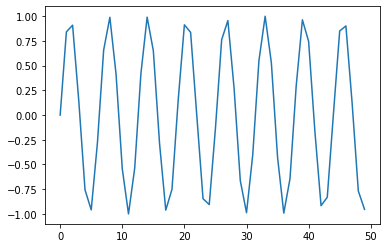

In [3]:
plt.plot(sin_wave[:50])

In [4]:
X = []
Y = []
seq_len = 50
num_records = len(sin_wave) - seq_len

for i in  range(num_records - 50):
    X.append(sin_wave[i:i + seq_len])
    Y.append(sin_wave[i + seq_len])
X = np.array(X)
X = np.expand_dims(X, axis=2)

Y = np.array(Y)
Y = np.expand_dims(Y, axis=1)

In [5]:
X.shape, Y.shape

((100, 50, 1), (100, 1))

In [6]:
X_val = []
Y_val = []

for i in range(num_records - 50, num_records):
    X_val.append(sin_wave[i: seq_len + i])
    Y_val.append(sin_wave[seq_len + i])

X_val = np.array(X_val)
X_val = np.expand_dims(X_val, axis=2)
Y_val = np.array(Y_val)
Y_val = np.expand_dims(Y_val, axis=1)

In [7]:
learning_rate = 0.0001
nepoch = 25
T = 50  # length of sequence
hidden_dim = 100
output_dim = 1
bptt_truncate = 5  # truncated back propagation through time
max_clip_value = 10
min_clip_value = -10

* U is the weight matrix for weights between input and hidden layers
* V is the weight matrix for weights between hidden and output layers
* W is the weight matrix for shared weights in the RNN layer (hidden layer)

In [8]:
# defining random weights of the network
U = np.random.uniform(0, 1, (hidden_dim, T))
W = np.random.uniform(0, 1, (hidden_dim, hidden_dim))
V = np.random.uniform(0, 1, (output_dim, hidden_dim))

In [9]:
def sigmoid(x):
    """Activation Function"""
    return 1 / (1 + np.exp(-x))

In [10]:
for epoch in range(nepoch):
    # check loss on train
    loss = 0.0

    # do a forward pass to do a prediction
    for i in range(Y.shape[0]):
        x, y, = X[i], Y[i]                      # get input, output values of each record
        prev_s = np.zeros((hidden_dim, 1))      # here, prev_s is the value of the previous activation of hidden layer
                                                # which is initialized as all zeroes
        for t in range(T):
            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulu + mulw
            s = sigmoid(add)
            mulv = np.dot(V, s)
            prev_s = s
        # calculating error
        loss_per_record = (y - mulv)**2 / 2  # MSE
        loss += loss_per_record
    loss = loss / float(y.shape[0])

    # checking loss on validation
    val_loss = 0.0

    for i in range(Y_val.shape[0]):
        x, y = X_val[i], Y_val[i]
        prev_s = np.zeros((hidden_dim, 1))

        for t in range(T):
            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulu + mulw
            s = sigmoid(add)
            mulv = np.dot(V, s)
            prev_s = s

        loss_per_record = (y - mulv) ** 2 / 2
        val_loss += loss_per_record
    val_loss = val_loss / float(y.shape[0])
    print(f'Epoch: {epoch+1}, Loss: {loss}, Val Loss: {val_loss}')

    # training model
    for i in range(Y.shape[0]):
        x, y = X[i], Y[i]
        layers = []
        prev_s = np.zeros((hidden_dim, 1))
        dU = np.zeros(U.shape)
        dV = np.zeros(V.shape)
        dW = np.zeros(W.shape)

        dU_t = np.zeros(U.shape)
        dV_t = np.zeros(V.shape)
        dW_t = np.zeros(W.shape)

        dU_i = np.zeros(U.shape)
        dW_i = np.zeros(W.shape)

        # forward pass
        for t in range(T):
            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            layers.append({'s': s, 'prev_s': prev_s})
            prev_s = s

        # derivative of pred
        dmulv = (mulv - y)

        # backward pass
        for t in range(T):
            dV_t = np.dot(dmulv, np.transpose(layers[t]['s']))
            dsv = np.dot(np.transpose(V), dmulv)
            ds = dsv
            dadd = add * (1 - add) * ds
            dmulw = dadd * np.ones_like(mulw)
            dprev_s = np.dot(np.transpose(W), dmulw)

            for i in range(t-1, max(-1, t-bptt_truncate-1), -1):
                ds = dsv + dprev_s
                dadd = add * (1 - add) * ds
                dmulw = dadd * np.ones_like(mulw)
                dmulu = dadd * np.ones_like(mulu)

                dW_i = np.dot(W, layers[t]['prev_s'])
                dprev_s = np.dot(np.transpose(W), dmulw)
                new_input = np.zeros(x.shape)
                new_input[t] = [t]
                dU_i = np.dot(U, new_input)
                dx = np.dot(np.transpose(U), dmulu)
                dU_t += dU_i
                dW_t += dW_i

            dV += dV_t
            dU += dU_t
            dW += dW_t

            if dU.max() > max_clip_value:
                dU[dU > max_clip_value] = max_clip_value
            if dV.max() > max_clip_value:
                dV[dV > max_clip_value] = max_clip_value
            if dW.max() > max_clip_value:
                dW[dW > max_clip_value] = max_clip_value

            if dU.min() < min_clip_value:
                dU[dU < min_clip_value] = min_clip_value
            if dV.min() < min_clip_value:
                dV[dV < min_clip_value] = min_clip_value
            if dW.min() < min_clip_value:
                dW[dW < min_clip_value] = min_clip_value
        # update
        U -= learning_rate * dU
        V -= learning_rate * dV
        W -= learning_rate * dW

Epoch: 1, Loss: [[105745.11353284]], Val Loss: [[52870.74332413]]
Epoch: 2, Loss: [[64762.4677659]], Val Loss: [[32379.80621472]]
Epoch: 3, Loss: [[33779.82199891]], Val Loss: [[16888.86910529]]
Epoch: 4, Loss: [[12797.17692526]], Val Loss: [[6397.93234273]]
Epoch: 5, Loss: [[1828.99537624]], Val Loss: [[914.22906474]]
Epoch: 6, Loss: [[32.25692381]], Val Loss: [[16.08467167]]
Epoch: 7, Loss: [[25.71085349]], Val Loss: [[12.82770024]]
Epoch: 8, Loss: [[26.69027992]], Val Loss: [[13.31997552]]
Epoch: 9, Loss: [[25.35648396]], Val Loss: [[12.64995268]]
Epoch: 10, Loss: [[25.1839432]], Val Loss: [[12.56079091]]
Epoch: 11, Loss: [[26.11173114]], Val Loss: [[13.02920872]]
Epoch: 12, Loss: [[25.17951439]], Val Loss: [[12.56019767]]
Epoch: 13, Loss: [[25.32755097]], Val Loss: [[12.63094557]]
Epoch: 14, Loss: [[25.56520426]], Val Loss: [[12.75427114]]
Epoch: 15, Loss: [[25.31109824]], Val Loss: [[12.62608574]]
Epoch: 16, Loss: [[25.13033046]], Val Loss: [[12.53467923]]
Epoch: 17, Loss: [[25.66

In [12]:
preds = []
for i in range(Y.shape[0]):
    x, y = X[i], Y[i]
    prev_s = np.zeros((hidden_dim, 1))
    # forward pass
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulu + mulw
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s
    preds.append(mulv)
preds = np.array(preds)

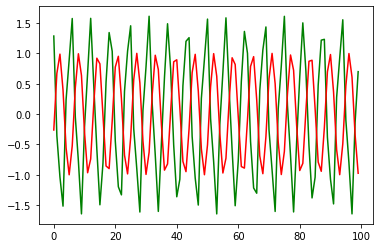

In [13]:
plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y[:, 0], 'r')
plt.show()

In [16]:
preds = []
for i in range(Y_val.shape[0]):
    x, y = X_val[i], Y_val[i]
    prev_s = np.zeros((hidden_dim, 1))
    # for each time step
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s
    preds.append(mulv)
preds = np.array(preds)

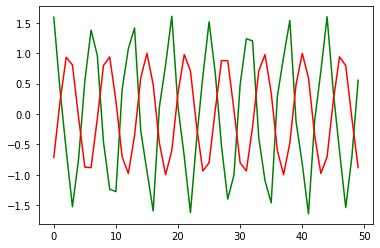

In [17]:
plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y_val[:, 0], 'r')
plt.show()

In [12]:
# below is copied code from here
# https://www.analyticsvidhya.com/blog/2019/01/fundamentals-deep-learning-recurrent-neural-networks-scratch-python/

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sin_wave = np.array([math.sin(x) for x in np.arange(200)])

In [3]:
X = []
Y = []

seq_len = 50
num_records = len(sin_wave) - seq_len

for i in range(num_records - 50):
    X.append(sin_wave[i:i+seq_len])
    Y.append(sin_wave[i+seq_len])

X = np.array(X)
X = np.expand_dims(X, axis=2)

Y = np.array(Y)
Y = np.expand_dims(Y, axis=1)

In [4]:
X_val = []
Y_val = []

for i in range(num_records - 50, num_records):
    X_val.append(sin_wave[i:i+seq_len])
    Y_val.append(sin_wave[i+seq_len])

X_val = np.array(X_val)
X_val = np.expand_dims(X_val, axis=2)

Y_val = np.array(Y_val)
Y_val = np.expand_dims(Y_val, axis=1)

In [5]:
learning_rate = 0.0001
nepoch = 25
T = 50                   # length of sequence
hidden_dim = 100
output_dim = 1

bptt_truncate = 5
min_clip_value = -10
max_clip_value = 10

In [6]:
U = np.random.uniform(0, 1, (hidden_dim, T))
W = np.random.uniform(0, 1, (hidden_dim, hidden_dim))
V = np.random.uniform(0, 1, (output_dim, hidden_dim))

In [7]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [8]:
for epoch in range(nepoch):
    # check loss on train
    loss = 0.0

    # do a forward pass to get prediction
    for i in range(Y.shape[0]):
        x, y = X[i], Y[i]                    # get input, output values of each record
        prev_s = np.zeros((hidden_dim, 1))   # here, prev-s is the value of the previous activation of hidden layer; which is initialized as all zeroes
        for t in range(T):
            new_input = np.zeros(x.shape)    # we then do a forward pass for every timestep in the sequence
            new_input[t] = x[t]              # for this, we define a single input for that timestep
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            prev_s = s

        # calculate error
        loss_per_record = (y - mulv)**2 / 2
        loss += loss_per_record
    loss = loss / float(y.shape[0])
    # check loss on val
    val_loss = 0.0
    for i in range(Y_val.shape[0]):
        x, y = X_val[i], Y_val[i]
        prev_s = np.zeros((hidden_dim, 1))
        for t in range(T):
            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            prev_s = s

        loss_per_record = (y - mulv)**2 / 2
        val_loss += loss_per_record
    val_loss = val_loss / float(y.shape[0])

    print('Epoch: ', epoch + 1, ', Loss: ', loss, ', Val Loss: ', val_loss)
    # train model
    for i in range(Y.shape[0]):
        x, y = X[i], Y[i]

        layers = []
        prev_s = np.zeros((hidden_dim, 1))
        dU = np.zeros(U.shape)
        dV = np.zeros(V.shape)
        dW = np.zeros(W.shape)

        dU_t = np.zeros(U.shape)
        dV_t = np.zeros(V.shape)
        dW_t = np.zeros(W.shape)

        dU_i = np.zeros(U.shape)
        dW_i = np.zeros(W.shape)

        # forward pass
        for t in range(T):
            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            layers.append({'s':s, 'prev_s':prev_s})
            prev_s = s
        # derivative of pred
        dmulv = (mulv - y)

        # backward pass
        for t in range(T):
            dV_t = np.dot(dmulv, np.transpose(layers[t]['s']))
            dsv = np.dot(np.transpose(V), dmulv)

            ds = dsv
            dadd = add * (1 - add) * ds

            dmulw = dadd * np.ones_like(mulw)

            dprev_s = np.dot(np.transpose(W), dmulw)


            for i in range(t-1, max(-1, t-bptt_truncate-1), -1):
                ds = dsv + dprev_s
                dadd = add * (1 - add) * ds

                dmulw = dadd * np.ones_like(mulw)
                dmulu = dadd * np.ones_like(mulu)

                dW_i = np.dot(W, layers[t]['prev_s'])
                dprev_s = np.dot(np.transpose(W), dmulw)

                new_input = np.zeros(x.shape)
                new_input[t] = x[t]
                dU_i = np.dot(U, new_input)
                dx = np.dot(np.transpose(U), dmulu)

                dU_t += dU_i
                dW_t += dW_i

            dV += dV_t
            dU += dU_t
            dW += dW_t
            if dU.max() > max_clip_value:
                dU[dU > max_clip_value] = max_clip_value
            if dV.max() > max_clip_value:
                dV[dV > max_clip_value] = max_clip_value
            if dW.max() > max_clip_value:
                dW[dW > max_clip_value] = max_clip_value


            if dU.min() < min_clip_value:
                dU[dU < min_clip_value] = min_clip_value
            if dV.min() < min_clip_value:
                dV[dV < min_clip_value] = min_clip_value
            if dW.min() < min_clip_value:
                dW[dW < min_clip_value] = min_clip_value

        # update
        U -= learning_rate * dU
        V -= learning_rate * dV
        W -= learning_rate * dW

Epoch:  1 , Loss:  [[122528.35086165]] , Val Loss:  [[61262.22636888]]
Epoch:  2 , Loss:  [[78030.18465012]] , Val Loss:  [[39013.52903717]]
Epoch:  3 , Loss:  [[43532.01843829]] , Val Loss:  [[21764.83170532]]
Epoch:  4 , Loss:  [[19033.84894331]] , Val Loss:  [[9516.13273081]]
Epoch:  5 , Loss:  [[4512.94411213]] , Val Loss:  [[2256.06118305]]
Epoch:  6 , Loss:  [[33.64162783]] , Val Loss:  [[16.74884357]]
Epoch:  7 , Loss:  [[37.62798609]] , Val Loss:  [[18.75364407]]
Epoch:  8 , Loss:  [[37.56613697]] , Val Loss:  [[18.72298712]]
Epoch:  9 , Loss:  [[37.53743843]] , Val Loss:  [[18.71198046]]
Epoch:  10 , Loss:  [[37.50281945]] , Val Loss:  [[18.69289094]]
Epoch:  11 , Loss:  [[37.45683715]] , Val Loss:  [[18.66705715]]
Epoch:  12 , Loss:  [[37.76261897]] , Val Loss:  [[18.81914998]]
Epoch:  13 , Loss:  [[37.63873535]] , Val Loss:  [[18.75931169]]
Epoch:  14 , Loss:  [[37.56486157]] , Val Loss:  [[18.72318456]]
Epoch:  15 , Loss:  [[37.66736105]] , Val Loss:  [[18.77346397]]
Epoch:

In [9]:
preds = []
for i in range(Y.shape[0]):
    x, y = X[i], Y[i]
    prev_s = np.zeros((hidden_dim, 1))
    # Forward pass
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds.append(mulv)

preds = np.array(preds)

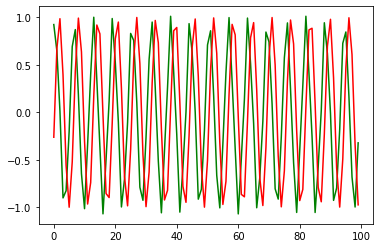

In [10]:
plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y[:, 0], 'r')
plt.show()

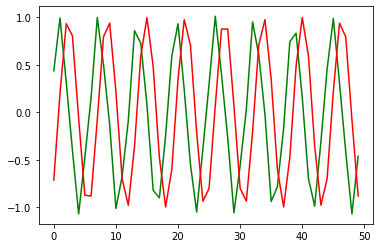

In [11]:
preds = []
for i in range(Y_val.shape[0]):
    x, y = X_val[i], Y_val[i]
    prev_s = np.zeros((hidden_dim, 1))
    # For each time step...
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds.append(mulv)

preds = np.array(preds)

plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y_val[:, 0], 'r')
plt.show()